In [1]:
from analogainas.search_spaces.config_space import ConfigSpace
from analogainas.search_spaces.autoencoder.autoencoder_config_space import AutoEncoderConfigSpace
from analogainas.search_spaces.autoencoder.autoencoder_architecture import AutoEncoder
from analogainas.search_spaces.dataloaders.autoencoder_structured_dataset import AutoEncoderStructuredDataset
from analogainas.evaluators.evaluation_metrics import negative_mse_metric
from aihwkit.simulator.configs import InferenceRPUConfig
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from analogainas.analog_helpers.analog_helpers import create_rpu_config
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.configs.utils import WeightClipType
from aihwkit.simulator.configs.utils import BoundManagementType
from aihwkit.simulator.presets.utils import PresetIOParameters
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.nn.conversion import convert_to_analog_mapped
from aihwkit.nn import AnalogSequential
from aihwkit.optim import AnalogSGD
import aihwkit.inference.noise.pcm as pcm

import aihwkit

print(aihwkit.__version__)

0.9.0


In [3]:
noise_model = pcm.PCMLikeNoiseModel()
optimal_rpu_config_dict = {'g_max': 256, 'tile_size': 64, 'dac_resolution': 128, 'adc_resolution': 256}
rpu_config = create_rpu_config()
optimal_rpu_config = create_rpu_config(g_max=optimal_rpu_config_dict['g_max'], tile_size=optimal_rpu_config_dict['tile_size'], dac_res=optimal_rpu_config_dict['dac_resolution'], adc_res=optimal_rpu_config_dict['adc_resolution'])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
CS = AutoEncoderConfigSpace()

In [6]:
CS.get_hyperparameters()

['embedding_dim', 'encoder_convblock1_depth', 'encoder_convblock1_kernel_size', 'encoder_convblock1_filters', 'encoder_convblock1_stride', 'encoder_convblock2_depth', 'encoder_convblock2_kernel_size', 'encoder_convblock2_filters', 'encoder_convblock2_stride', 'encoder_convblock3_depth', 'encoder_convblock3_kernel_size', 'encoder_convblock3_filters', 'encoder_convblock3_stride', 'decoder_convblock1_depth', 'decoder_convblock1_kernel_size', 'decoder_convblock1_filters', 'decoder_convblock1_stride', 'decoder_convblock2_depth', 'decoder_convblock2_kernel_size', 'decoder_convblock2_filters', 'decoder_convblock2_stride', 'decoder_convblock3_depth', 'decoder_convblock3_kernel_size', 'decoder_convblock3_filters', 'decoder_convblock3_stride']


In [7]:
CS.compute_cs_size()

134898444140544

In [8]:
configs = CS.sample_arch_uniformly(5)

optimal_config={'embedding_dim': 256, 'encoder_convblock1_depth': 1, 'encoder_convblock1_kernel_size': 5, 'encoder_convblock1_filters': 64, 'encoder_convblock1_stride': 1, 'encoder_convblock2_depth': 1, 'encoder_convblock2_kernel_size': 3, 'encoder_convblock2_filters': 32, 'encoder_convblock2_stride': 1, 'encoder_convblock3_depth': 1, 'encoder_convblock3_kernel_size': 7, 'encoder_convblock3_filters': 16, 'encoder_convblock3_stride': 2}
suboptimal_config= {'embedding_dim': 64, 'encoder_convblock1_depth': 3, 'encoder_convblock1_kernel_size': 5, 'encoder_convblock1_filters': 16, 'encoder_convblock1_stride': 1, 'encoder_convblock2_depth': 3, 'encoder_convblock2_kernel_size': 3, 'encoder_convblock2_filters': 8, 'encoder_convblock2_stride': 2, 'encoder_convblock3_depth': 3, 'encoder_convblock3_kernel_size': 7, 'encoder_convblock3_filters': 128, 'encoder_convblock3_stride': 1}

new_optimal_config ={'embedding_dim': 2048,
 'encoder_convblock1_depth': 1,
 'encoder_convblock1_kernel_size': 3,
 'encoder_convblock1_filters': 256,
 'encoder_convblock1_stride': 1,
 'encoder_convblock2_depth': 1,
 'encoder_convblock2_kernel_size': 7,
 'encoder_convblock2_filters': 256,
 'encoder_convblock2_stride': 1,
 'encoder_convblock3_depth': 3,
 'encoder_convblock3_kernel_size': 3,
 'encoder_convblock3_filters': 32,
 'encoder_convblock3_stride': 2,
                    }

In [9]:
sample_autoencoder = AutoEncoder(optimal_config, input_channels=3, input_size=(32,32))

Need FC Out: False
Decoded Shape: torch.Size([3, 32, 32])
Input Size: (32, 32)


In [10]:
configs[0]

{'embedding_dim': 256,
 'encoder_convblock1_depth': 2,
 'encoder_convblock1_kernel_size': 5,
 'encoder_convblock1_filters': 256,
 'encoder_convblock1_stride': 2,
 'encoder_convblock2_depth': 1,
 'encoder_convblock2_kernel_size': 5,
 'encoder_convblock2_filters': 32,
 'encoder_convblock2_stride': 2,
 'encoder_convblock3_depth': 3,
 'encoder_convblock3_kernel_size': 3,
 'encoder_convblock3_filters': 512,
 'encoder_convblock3_stride': 1,
 'decoder_convblock1_depth': 2,
 'decoder_convblock1_kernel_size': 3,
 'decoder_convblock1_filters': 64,
 'decoder_convblock1_stride': 1,
 'decoder_convblock2_depth': 2,
 'decoder_convblock2_kernel_size': 5,
 'decoder_convblock2_filters': 8,
 'decoder_convblock2_stride': 1,
 'decoder_convblock3_depth': 2,
 'decoder_convblock3_kernel_size': 3,
 'decoder_convblock3_filters': 32,
 'decoder_convblock3_stride': 1}

In [11]:
def show_performance(_autoencoder,_dataloader, normalize=True):
    images, labels = next(iter(_dataloader))
    _autoencoder = _autoencoder.to(torch.device('cpu'))
    with torch.no_grad():
        reconstructions = _autoencoder(images)
    
    def show_image(img_tensor, title="", normalize=True):
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        if normalize:
            mean = np.array([0.4914, 0.4822, 0.4465])
            std = np.array([0.2023, 0.1994, 0.2010])
            img = (img * std) + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    
    for i in range(8):
        plt.sca(axes[0, i])
        show_image(images[i], title="Original")
        plt.sca(axes[1, i])
        show_image(reconstructions[i], title="Reconstructed", normalize=normalize)
    
    sample_autoencoder.to(torch.device('cpu'))
    negative_mse = negative_mse_metric(_dataloader, _autoencoder)
    print("Negative MSE: ", sum(negative_mse)/len(negative_mse))
    plt.tight_layout()
    plt.show()


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)) 
])

train_cifar_dataset = AutoEncoderStructuredDataset(
    torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
)

dataloader = DataLoader(train_cifar_dataset, batch_size=8, shuffle=True)

test_cifar_dataset = AutoEncoderStructuredDataset(
    torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
)

test_dataloader = DataLoader(test_cifar_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(sample_autoencoder.parameters(), lr=1e-3)
optimizer = optim.SGD(sample_autoencoder.parameters(), lr=1e-3)

sample_autoencoder = sample_autoencoder.to(device)
epochs = 15
sample_autoencoder.train()

AutoEncoder(
  (encoder): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): ReLU(inplace=True)
      )
    )
  )
  (fc_mu): Linear(in_features=4096, out_features=256, bias=True)
  (fc_dec): Linear(in_features=256, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): DeconvBlock(
      (block): Sequential(
        (0): ConvTranspose2d(16, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DeconvBlock(
      (block): Sequential(
        (0): ConvTranspose2d(16,

In [16]:
for epoch in range(epochs):
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        recon = sample_autoencoder(images)
        loss = criterion(recon, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx}], Loss: {loss.item()}")

Epoch [1/15], Step [0], Loss: 0.06469212472438812
Epoch [1/15], Step [50], Loss: 0.040414389222860336
Epoch [1/15], Step [100], Loss: 0.05620472878217697
Epoch [1/15], Step [150], Loss: 0.05769897252321243
Epoch [1/15], Step [200], Loss: 0.058768779039382935
Epoch [1/15], Step [250], Loss: 0.05472252517938614
Epoch [1/15], Step [300], Loss: 0.0656595304608345
Epoch [1/15], Step [350], Loss: 0.057329289615154266
Epoch [1/15], Step [400], Loss: 0.05011171102523804
Epoch [1/15], Step [450], Loss: 0.0663408562541008
Epoch [1/15], Step [500], Loss: 0.05961991474032402
Epoch [1/15], Step [550], Loss: 0.0566289983689785
Epoch [1/15], Step [600], Loss: 0.05278487503528595
Epoch [1/15], Step [650], Loss: 0.06372140347957611
Epoch [1/15], Step [700], Loss: 0.0670662596821785
Epoch [1/15], Step [750], Loss: 0.04965590685606003
Epoch [1/15], Step [800], Loss: 0.04886393994092941
Epoch [1/15], Step [850], Loss: 0.06633307039737701
Epoch [1/15], Step [900], Loss: 0.057963453233242035
Epoch [1/15], S

KeyboardInterrupt: 

Negative MSE:  -0.055218543857336044


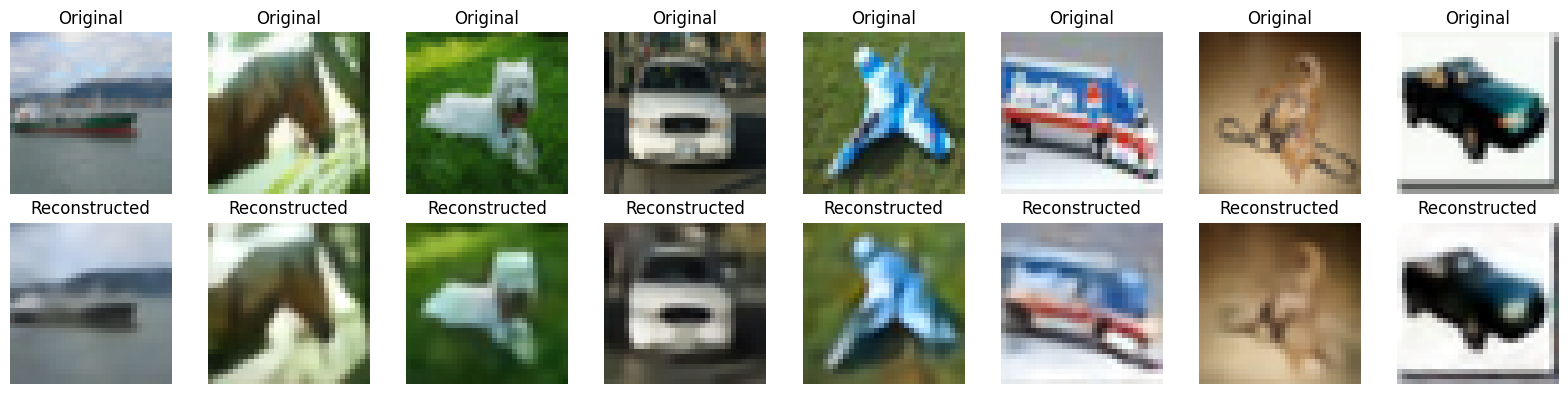

In [17]:
show_performance(sample_autoencoder, test_dataloader)

In [20]:
device = torch.device('cpu')
analog_sample_autoencoder = sample_autoencoder.to(torch.device('cpu'))
analog_sample_autoencoder.eval()
analog_sample_autoencoder = convert_to_analog_mapped(sample_autoencoder, rpu_config)

#analog_sample_autoencoder.drift_analog_weights(24 * 60 * 60 * 1)

One Day Performance
Negative MSE:  -1.3987444639205933


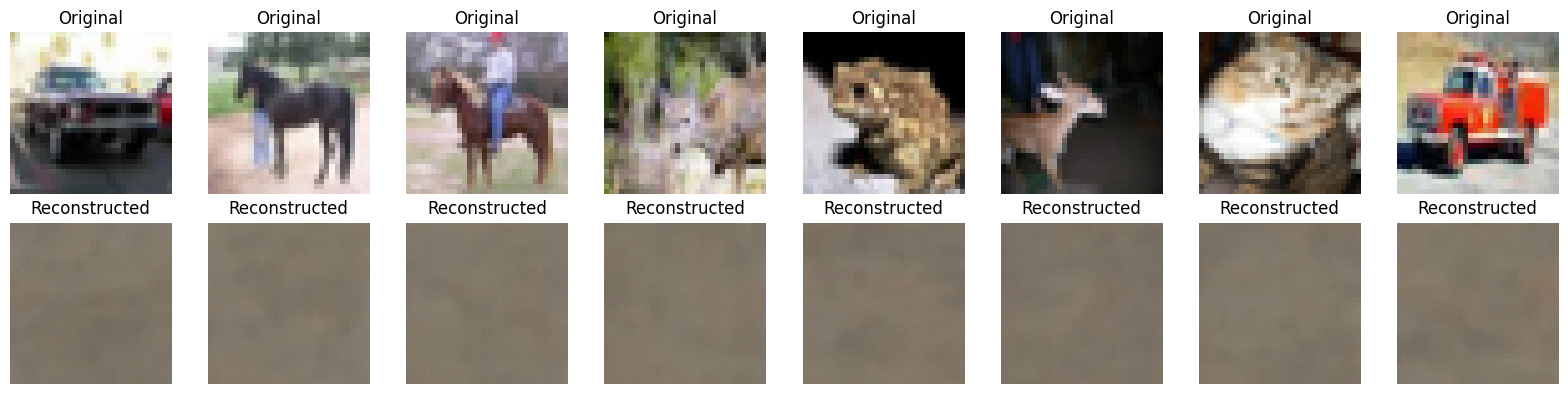

In [26]:
print("One Day Performance")
show_performance(analog_sample_autoencoder, dataloader, normalize=True)

In [ ]:
analog_sample_autoencoder.drift_analog_weights(24 * 60 * 60 * 30)

In [ ]:
print("One Month Performance")
show_performance(analog_sample_autoencoder, test_dataloader)

In [22]:
device = torch.device('cpu')
analog_sample_autoencoder = sample_autoencoder.to(torch.device('cpu'))
analog_sample_autoencoder.eval()
analog_sample_autoencoder = convert_to_analog_mapped(sample_autoencoder, optimal_rpu_config)

analog_sample_autoencoder.drift_analog_weights(24 * 60 * 60 * 1)

One Day Performance (Optimal RPU)
Negative MSE:  -1.4327465466090612


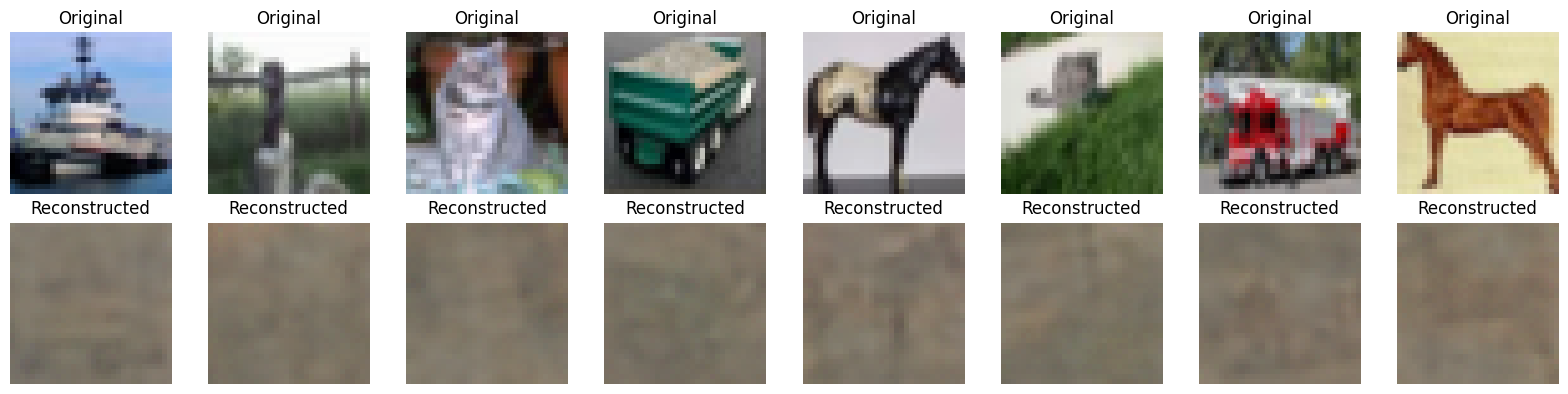

In [23]:
print("One Day Performance (Optimal RPU)")
show_performance(analog_sample_autoencoder, test_dataloader)

In [24]:
analog_sample_autoencoder.drift_analog_weights(24 * 60 * 60 * 30)

One Month Performance (Optimal RPU)
Negative MSE:  -1.4940057822636195


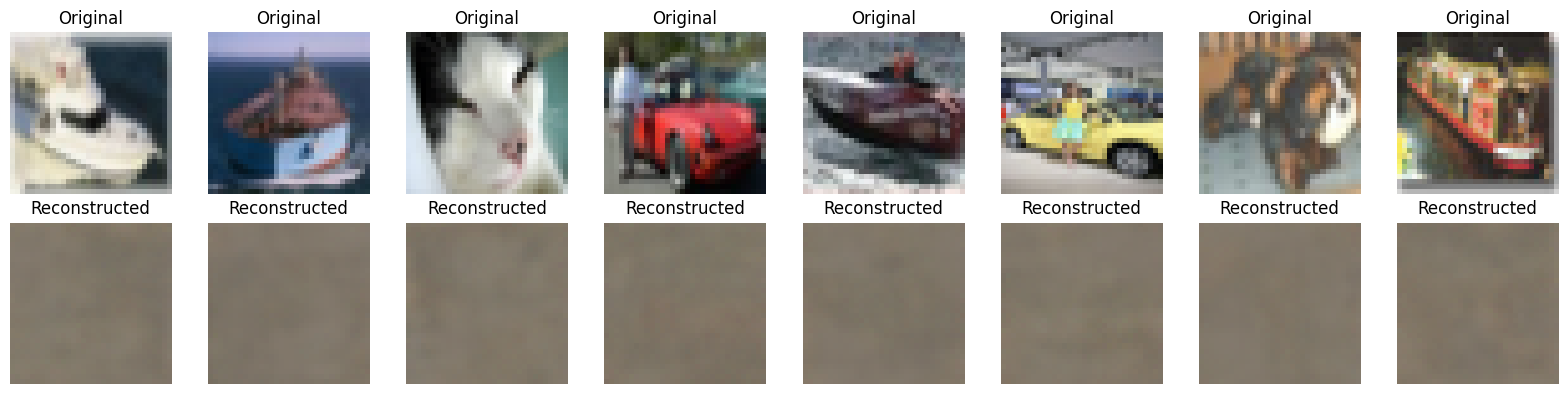

In [25]:
print("One Month Performance (Optimal RPU)")
show_performance(analog_sample_autoencoder, test_dataloader)